# Step 3: Cluster Distribution Statistical Analysis
Calculate statstical information on cluster distributions isolated in the 'Step 2' Cluster Network Isolation notebook. 

---
Here, we can compute information such as:

- Coordination Number Distributions
- Bond Length, Angle Distributions
- Volume Distributions
- Cluster Atom Count Distributions
- Volume Fraction (Scattering) Contributions

## Custom Imports
Relative import the custom classes to support the cluster network tool.

In [1]:
# Import and run the setup script
import sys, os
import numpy as np
from typing import TypedDict, Optional, Dict

# Ensure the project root is in sys.path to locate setup_env
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Import the setup helper and configure the environment
from setup_env import setup_environment

# Capture the imported classes from setup_environment
calculate_number_density, DebyerBatch, prunePDB, BulkVolumeParams, BulkVolume, RadiusOfGyrationCalculator, PDBEditor, TrajectoryProcessor, PDBFileHandler, Atom, ClusterNetwork, ClusterBatchAnalyzer = setup_environment()

Scripts directory '/Users/keithwhite/repos/MDScatter/scripts' has been added to sys.path.
Class imports have been set up.


## Cluster Single Frame Analysis

### Bond Length and Angle Distributions

In [ ]:
# Define the path to the PDB file and initialize the handler
pdb_file_path = '/Users/keithwhite/repos/MDScatter/data/example/frame_0001.pdb'
core_residue_names = ['PBI']
shell_residue_names = ['DMS']
pdb_handler = PDBFileHandler(pdb_file_path, core_residue_names, shell_residue_names)

# Initialize ClusterNetwork with relevant parameters
node_elements = ['Pb']
linker_elements = ['Pb', 'I']
terminator_elements = ['I']
segment_cutoff = 3.7
cluster_network = ClusterNetwork(
    pdb_handler.core_atoms,
    pdb_handler.shell_atoms,
    node_elements,
    linker_elements,
    terminator_elements,
    segment_cutoff,
    core_residue_names,
    shell_residue_names
)

# Analyze networks
networks = cluster_network.analyze_networks()

# Specify bond lengths and angles to calculate
# bond_length_pairs = [('Pb', 'I', 3.8), ('I', 'I', 7.6)]
bond_length_pairs = [('Pb', 'I', 3.8)] #, ('I', 'I', 7.6)]
bond_angle_triplets = [('I', 'Pb', 'I', 3.8)]

# Calculate and plot distributions
cluster_network.calculate_and_plot_distributions(bond_length_pairs, bond_angle_triplets)

### Coordination Number Distributions

In [ ]:
# Calculate coordination numbers
target_elements = ['Pb']
neighbor_elements = ['I', 'O']
distance_thresholds = {('Pb', 'I'): 3.8, ('Pb', 'O'): 3}
coordination_stats, total_stats = cluster_network.calculate_coordination_numbers(target_elements, neighbor_elements, distance_thresholds)

# Print coordination numbers
cluster_network.print_coordination_numbers(coordination_stats, total_stats)

### Coordination Number Heatmap

In [ ]:
# Define parameters for the heatmap
central_element = 'Pb'
x_pair = ('Pb', 'I')
y_pair = ('Pb', 'O')
x_range = (0, 6)  # Range for Pb-I coordination number
y_range = (0, 6)  # Range for Pb-O coordination number
distance_cutoffs = {('Pb', 'I'): 3.5, ('Pb', 'O'): 3}

# Calculate and plot the heatmap
cluster_network.calculate_and_plot_heatmap(central_element, x_pair, y_pair, x_range, y_range, distance_cutoffs)


## Cluster Batch Frame Analysis

### Setup
Checking coordination numbers and elements in Mendeleev data repository to help with input fields for cluster analyzer.

In [ ]:
from mendeleev import element

# Retrieve the element information for oxygen
oxygen = element('I')

# Fetch the ionic radii for oxygen in different oxidation states
ionic_radii = oxygen.ionic_radii

# Print the ionic radii for each oxidation state
for ir in ionic_radii:
    print(f"Oxidation State: {ir.charge}, Coordination: {ir.coordination}, Ionic Radius: {ir.ionic_radius} pm")


### Setup the Cluster Batch Analyzer

#### Batch Analyzer Settings

In [2]:
%matplotlib widget

## -- DEFINE THE PDB FOLDER PATH
pdb_directory = '/Users/keithwhite/repos/MDScatter/data/PbI2_DMSO_0p8M_cr_nb/clusters_pdb_sc3p7_PbO-3'

## -- SETUP FOR FIRST COORDINATION SHELL
target_elements = ['Pb']
neighbor_elements = ['O', 'I']
distance_thresholds = {
    ('Pb', 'O'): 3.0,  # Example threshold distances in angstroms
    ('Pb', 'I'): 3.7
}

## -- FOR CHARGE DISTRIBUTION CALCULATION - USE SETUP TOOL TO SET THESE VALUES
partial_charges = {
    'Pb': (2, 6),    # Lead with a charge of 2+ and coordination number of 6
    'I': (-1, 6),    # Iodine with a charge of 1- and coordination number of 6
    'S': (-2, 6),    # Sulfur in DMSO with a neutral charge and coordination number of 2
    'O': (-2, 2),    # Oxygen in DMSO with a charge of 2- and coordination number of 2
    'C': (4, 4),     # Carbon in DMSO with a neutral charge and coordination number of 4
    'H': (1, 1)      # Hydrogen in DMSO with a neutral charge and coordination number of 1
}

## -- DEFINE THE PARAMETERS FOR BULK VOLUME ESTIMATION FROM EXPERIMENTAL MEASUREMENTS
BulkVolumeParams = {
    'mass_percent_solute': 25.83,
    'density_solution': 1.403,
    'density_neat_solvent': 1.1,
    'molar_mass_solvent': 78.13,
    'molar_mass_solute': 461.0,
    'ionic_radii': {
        'Pb': 1.19,
        'I': 2.20
    },
    'stoichiometry': {
        'Pb': 1,
        'I': 2
    },
    'atomic_masses': {
        'Pb': 207.2,
        'I': 126.9
    },
    'solute_residues': {
        'Pb': 'PBI',
        'I': 'PBI'
    },
    'solvent_name': 'DMS',
    'total_mass': 1.403
}

#### Initialization

In [3]:
# Instantiate the ClusterBatchAnalyzer class with the necessary parameters
analyzer = ClusterBatchAnalyzer(
    pdb_directory=pdb_directory,
    target_elements=target_elements,
    neighbor_elements=neighbor_elements,
    distance_thresholds=distance_thresholds,
    charges=partial_charges,
    core_residue_names=['PBI'], 
    shell_residue_names=['DMS'],
    # volume_method='ionic_radius'  # Choose the ionic radius estimation method
    # volume_method='radius_of_gyration'  # Choose the radius of gyration method
    volume_method='bulk_volume',  # Choose the radius of gyration method,
    bulk_volume_params = BulkVolumeParams
)

BulkVolume has been successfully initialized.
Mass of Solute: 0.3624 g
Mass of Solvent (DMS): 1.0406 g
Total Volume of Solution: 1.000000 cm³
Moles of Solute: 0.000786 mol
Moles of Solvent (DMS): 0.013319 mol
Number of Pb Atoms in Residue PBI: 4.7339e+20 atoms
Number of I Atoms in Residue PBI: 9.4679e+20 atoms
Number of Solvent (DMS) Molecules: 8.0206e+21 molecules
Volume per Solvent Molecule (DMS): 1.179463e-22 cm³/molecule
Total Volume Occupied by Solvent (DMS): 0.946005 cm³
Volume Fraction of Solvent (DMS): 94.60%
Volume Fraction of Solute: 5.40%
Volume Fraction of Pb in Residue PBI: 0.40%
Volume Fraction of I in Residue PBI: 5.00%
Volume Occupied by Pb in Residue PBI: 0.003959 cm³
Volume Occupied by I in Residue PBI: 0.050036 cm³
Volume conservation validated: Sum of volume fractions is approximately 100%.

Estimated Volumes (in cubic angstroms, Å³), Counts, and Volume Fractions:

Residue DMS - Solvent:
  Count: 8.0206e+21 molecules
  Total Volume: 9.4600e+23 Å³
  Volume Fraction: 

### Statistical Analysis of Clusters

Error processing file /Users/keithwhite/repos/MDScatter/data/PbI2_DMSO_0p8M_cr_nb/clusters_pdb_sc3p7_PbO-3/frame_0132_AAL.pdb: Electrons information (electrons_info) must be provided before calculating electron density.Error processing file /Users/keithwhite/repos/MDScatter/data/PbI2_DMSO_0p8M_cr_nb/clusters_pdb_sc3p7_PbO-3/frame_0208_ABD.pdb: Electrons information (electrons_info) must be provided before calculating electron density.
Error processing file /Users/keithwhite/repos/MDScatter/data/PbI2_DMSO_0p8M_cr_nb/clusters_pdb_sc3p7_PbO-3/frame_0047_ABK.pdb: Electrons information (electrons_info) must be provided before calculating electron density.
Error processing file /Users/keithwhite/repos/MDScatter/data/PbI2_DMSO_0p8M_cr_nb/clusters_pdb_sc3p7_PbO-3/frame_0132_ABW.pdb: Electrons information (electrons_info) must be provided before calculating electron density.

Error processing file /Users/keithwhite/repos/MDScatter/data/PbI2_DMSO_0p8M_cr_nb/clusters_pdb_sc3p7_PbO-3/frame_0098_AB

Processing PDB files:   0%|                                               | 0/12391 [00:00<?, ?it/s]

Error processing file /Users/keithwhite/repos/MDScatter/data/PbI2_DMSO_0p8M_cr_nb/clusters_pdb_sc3p7_PbO-3/frame_0210_AAY.pdb: Electrons information (electrons_info) must be provided before calculating electron density.
Error processing file /Users/keithwhite/repos/MDScatter/data/PbI2_DMSO_0p8M_cr_nb/clusters_pdb_sc3p7_PbO-3/frame_0226_ABW.pdb: Electrons information (electrons_info) must be provided before calculating electron density.
Error processing file /Users/keithwhite/repos/MDScatter/data/PbI2_DMSO_0p8M_cr_nb/clusters_pdb_sc3p7_PbO-3/frame_0200_ABB.pdb: Electrons information (electrons_info) must be provided before calculating electron density.
Error processing file /Users/keithwhite/repos/MDScatter/data/PbI2_DMSO_0p8M_cr_nb/clusters_pdb_sc3p7_PbO-3/frame_0064_ABD.pdb: Electrons information (electrons_info) must be provided before calculating electron density.
Error processing file /Users/keithwhite/repos/MDScatter/data/PbI2_DMSO_0p8M_cr_nb/clusters_pdb_sc3p7_PbO-3/frame_0226_AA

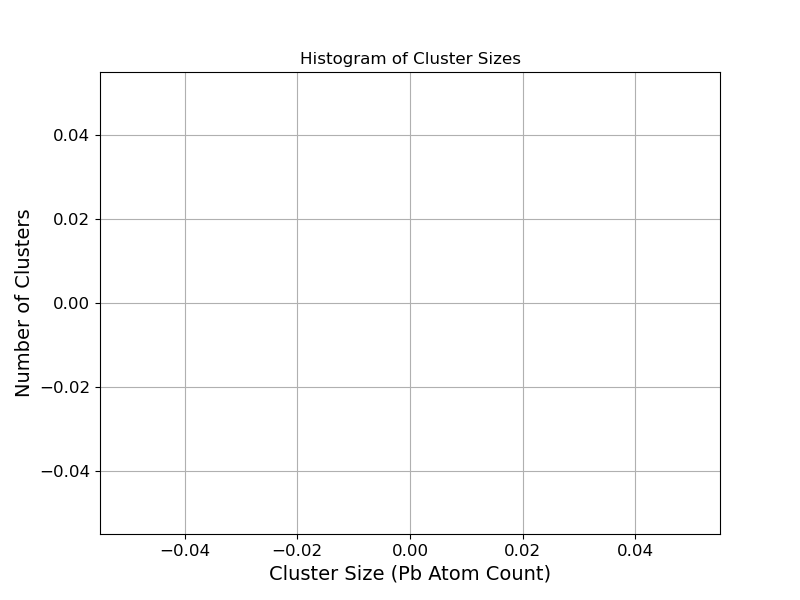

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


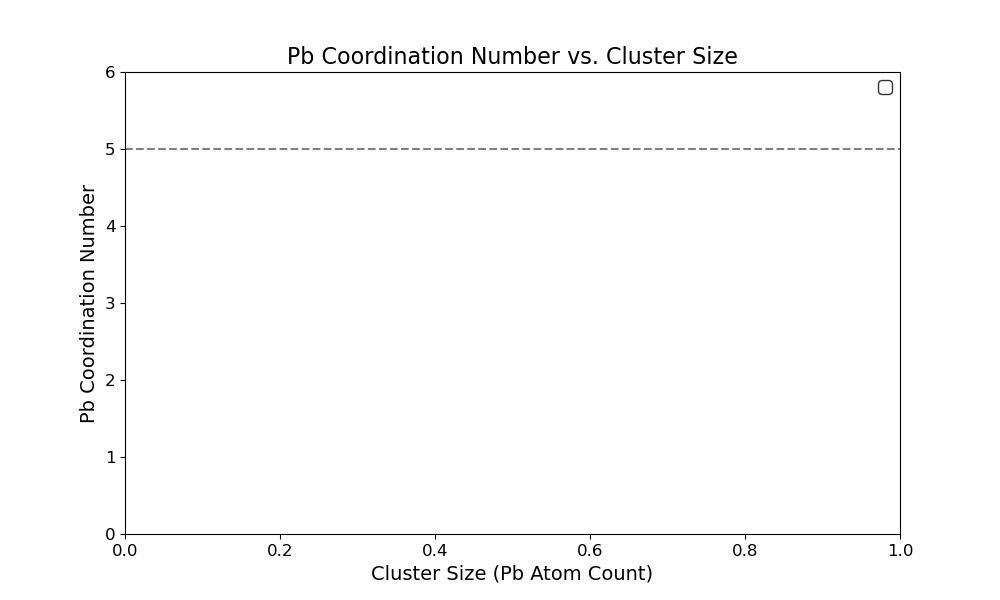

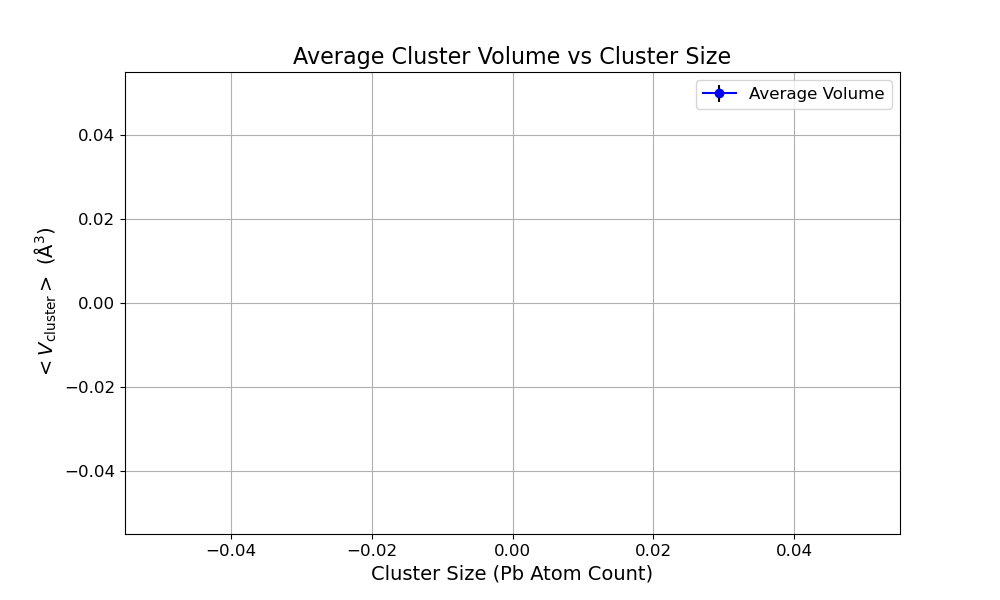

ValueError: attempt to get argmax of an empty sequence

In [4]:
## -- Analyze clusters to compute coordination numbers and volumes
# Specify shape_type='sphere' to use spherical approximation with radius of gyration

coordination_stats_per_size = analyzer.analyze_clusters(shape_type='sphere')
# coordination_stats_per_size = analyzer.analyze_clusters(shape_type='ellipsoid')

## Sorted Cluster Analysis

### Sort Clusters into Folders by Node Element Count
Description: Sort the clusters in your source PDB folder by the number of counts of individual node elements. This step will also determine the coordination statistics and sharing patterns within the distribution of your clusters, for later plotting.

In [ ]:
analyzer.sort_pdb_files_by_node_count(node_elements=['Pb'])

### Calculate Coordination Number & Sharing Statistics

In [ ]:
# User provides the path to the sorted folder
sorted_pdb_folder = '/Users/keithwhite/repos/MDScatter/data/PbI2_DMSO_0p8M_cr_nb/sorted_clusters_pdb_sc3p7_PbO-3'

# Define the target and neighbor elements
target_elements = ['Pb']  # Example target elements
neighbor_elements = ['O', 'I']  # Example neighbor elements

# Define distance thresholds for atom pairs
distance_thresholds = {
    ('Pb', 'O'): 3.0,  # Threshold distances in angstroms
    ('Pb', 'I'): 3.7
}

# Run the coordination calculation with distance thresholds
coordination_stats, sharing_patterns = analyzer.calculate_coordination_stats_by_subfolder(
    sorted_pdb_folder=sorted_pdb_folder,
    target_elements=target_elements,
    neighbor_elements=neighbor_elements,
    distance_thresholds=distance_thresholds
)

# Print coordination statistics per subfolder
for subfolder, stats in coordination_stats.items():
    print(f"\nSubfolder: {subfolder}")
    for pair, counts in stats.items():
        mean = np.mean(counts)
        std = np.std(counts)
        print(f"  {pair[0]} coordinated by {pair[1]}: Mean = {mean:.2f}, Std Dev = {std:.2f}")

# Generate tables per folder
for subfolder, multiplicity_counts in analyzer.per_folder_multiplicity_counts.items():
    analyzer.generate_ascii_table(multiplicity_counts, title=f"Multiplicity Counts for Folder: {subfolder}")

# Generate overall table
analyzer.generate_ascii_table(analyzer.overall_multiplicity_counts, title="Overall Multiplicity Counts Across All Folders")

# Report the sharing patterns
print("\nSharing Patterns:")
for pattern, count in sharing_patterns.items():
    num_targets, target_element, num_neighbors, neighbor_element = pattern
    print(f"{count} instance(s) of {num_targets} {target_element} atom(s) sharing {num_neighbors} {neighbor_element} atom(s)")

### Plotting 'Sorted' Cluster Analysis
- Average Coordination Number Histogram
- Coordination Number Distribution Heatmap
- Coordination Number Histogram: Total Coordination Number
- Coordination Number Histrogram: Neighbor Specific Coordination Number
- Sharing Patterns Histogram
- Sharing Patterns Heatmap

##### Average Coordination Number Histogram

In [ ]:
# Plot average coordination numbers
analyzer.plot_average_coordination_numbers()

# # Plot coordination number distribution
# analyzer.plot_coordination_number_distribution()

##### Coordination Number Heatmap

In [ ]:
# Define the central element and neighbor elements
central_element = 'Pb'
neighbor_elements = ['I', 'O']  # Exactly two neighbor elements

# Define the ranges for coordination numbers
x_range = (0, 6)  # For 'I' coordination numbers ranging from 0 to 8
y_range = (0, 8)  # For 'O' coordination numbers ranging from 0 to 8

# Call the method to calculate and plot the heatmap
analyzer.calculate_and_plot_coordination_heatmap_from_data(
    central_element=central_element,
    neighbor_elements=neighbor_elements,
    x_range=x_range,
    y_range=y_range
)

##### Coordination Number Histogram
Plot 1: Coordination number distribution by total coordination number. Fractional bins provide information on constituents coordinating to form that total coordination number.

Plot 2: Neighbor specific coordination number. Pass the neighbor_atom you want to rebin. Color schemes preserved from Plot 1 in the rebinning process.

In [ ]:
# Prepare the coordination distribution data
analyzer.prepare_coordination_distribution_data()

# Use Case 1: Plot Coordination Number Distribution
analyzer.plot_coordination_number_distribution()
## Update this to use all white font, rather than dynamic font color?

# # Use Case 2: Plot Neighbor Atom Distribution for 'I'
analyzer.plot_neighbor_atom_distribution(neighbor_atom='I')

##### Test Sharing Patterns Distribution Calculation

In [ ]:
# Run the coordination calculation
coordination_stats, sharing_patterns = analyzer.calculate_coordination_stats_by_subfolder(
    sorted_pdb_folder=sorted_pdb_folder,
    target_elements=target_elements,
    neighbor_elements=neighbor_elements,
    distance_thresholds=distance_thresholds
)

# Access sharing pattern instances
instances = analyzer.sharing_pattern_instances

# For example, print the first instance
first_instance = instances[0]
print("First Sharing Instance:")
print(f"Number of Targets: {first_instance['num_targets']}")
print(f"Target Atom IDs: {first_instance['target_atom_ids']}")
print(f"Number of Neighbors: {first_instance['num_neighbors']}")
print(f"Neighbor Atom IDs: {first_instance['neighbor_atom_ids']}")
print(f"Pattern: {first_instance['pattern']}")
print(f"PDB File: {first_instance['pdb_file']}")


##### Sharing Pattern Distributions

In [ ]:
# After running calculate_coordination_stats_by_subfolder
coordination_stats, sharing_patterns = analyzer.calculate_coordination_stats_by_subfolder(
    sorted_pdb_folder=sorted_pdb_folder,
    target_elements=target_elements,
    neighbor_elements=neighbor_elements,
    distance_thresholds=distance_thresholds
)

# analyzer.plot_sharing_pattern_histogram(sharing_patterns, neighbor_atom='I')
analyzer.plot_sharing_pattern_histogram(sharing_patterns, target_atom='Pb', color_palette='tab20b')
## Update this eliminate degeneracy in counting sharing motifs. Seems like all atoms are being counted as 1_0 sharing.

##### Sharing Patterns Heatmap
Note: This method is still not refined.

In [ ]:
# Plot the sharing patterns heatmap
analyzer.plot_sharing_patterns_heatmap(sharing_patterns)

##### Testing Annotation Styles

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def test_multiple_L_annotations_multiple_bars():
    """
    Creates a test histogram with multiple main bars, each containing multiple smaller fractional blocks.
    Annotates small blocks externally with 'L' shapes of different lengths and staggered vertically
    to prevent overlapping within the same bar and with neighboring bars.
    The lowest 'L' in each bar is the widest and has the longest vertical stem, and each subsequent
    'L' above it is narrower and has a slightly shorter vertical stem.
    """
    # Sample data for two coordination numbers
    coordination_numbers = [3, 4]  # Two coordination numbers for demonstration

    # Fractional blocks for each coordination number: (Element, Count)
    fractional_blocks = {
        3: [
            ('A', 50),  # Large block
            ('B', 2),   # Small block 1
            ('C', 1)    # Small block 2
        ],
        4: [
            ('A', 80),  # Large block
            ('B', 4),   # Small block 1
            ('C', 3),   # Small block 2
            ('D', 2)    # Small block 3
        ]
    }

    # Define colors for elements
    element_colors = {
        'A': 'skyblue',
        'B': 'salmon',
        'C': 'lightgreen',
        'D': 'violet'
    }

    # Percentage threshold for external annotations
    threshold = 5.0  # Percentages below this will be annotated externally

    # Calculate total counts for each coordination number
    total_counts = {}
    for coord_num, blocks in fractional_blocks.items():
        total = sum(count for elem, count in blocks)
        total_counts[coord_num] = total

    # Calculate y_max for the plot to accommodate all annotations
    max_total = max(total_counts.values())
    y_max = max_total * 2  # Increased buffer to accommodate multiple annotations

    # Initialize the plot
    fig, ax = plt.subplots(figsize=(16, 10))
    ax.set_ylim(0, y_max)

    # Bar width and spacing
    bar_width = 0.6
    bar_spacing = 1.5  # Space between bars to prevent overlapping of annotations

    # Define 'L' shape parameters
    L_base_width = 0.3        # Width of the widest 'L'
    L_decrement = 0.05         # Decrease in width for each subsequent 'L'
    L_base_stem_length = 2.0   # Base stem length for the lowest 'L'
    L_stem_decrement = 0.3     # Decrease in stem length for each subsequent 'L'
    margin_between_Ls = 0.2    # Vertical margin between 'L' annotations to prevent overlap

    # Plot each main bar with fractional blocks
    for idx, coord_num in enumerate(coordination_numbers):
        blocks = fractional_blocks.get(coord_num, [])
        bottoms = 0
        # Extract small blocks and sort them from bottom to top
        small_blocks = [blk for blk in blocks if (blk[1] / total_counts[coord_num]) * 100 < threshold]
        num_small_blocks = len(small_blocks)
        
        # Initialize current_y for tracking top of last 'L' in this bar
        current_y = 0

        for blk_idx, (elem, count) in enumerate(blocks):
            pct = (count / total_counts[coord_num]) * 100
            color = element_colors.get(elem, 'grey')
            ax.bar(coord_num, count, bottom=bottoms, color=color, edgecolor='black', width=bar_width)

            if pct >= threshold:
                # Annotate inside the bar
                ax.text(
                    coord_num,
                    bottoms + count / 2,
                    f"{pct:.1f}%",
                    ha='center',
                    va='center',
                    color='white',
                    fontsize=12,
                    fontweight='bold'
                )
            else:
                # Annotate externally with 'L' shape
                # Calculate 'L' width and stem length based on annotation order
                # Lower 'L's are wider and have longer stems
                L_width = L_base_width - blk_idx * L_decrement
                L_width = max(L_width, 0.1)  # Ensure 'L' width doesn't become negative

                L_stem_length = L_base_stem_length - blk_idx * L_stem_decrement
                L_stem_length = max(L_stem_length, 1.0)  # Ensure 'L' stem length doesn't become too short

                # Calculate positions
                bar_edge_x = coord_num + bar_width / 2  # Right edge of the bar
                y_bottom = bottoms
                y_top = bottoms + count

                # 'L' originates from the right edge, centered vertically on the small block
                L_y_origin = y_bottom + count / 2

                # Adjust 'L' y_origin based on current_y to prevent overlap
                # If the 'L' would overlap with the previous one, shift it upwards
                desired_y = L_y_origin
                if desired_y < current_y + margin_between_Ls:
                    L_y_origin = current_y + margin_between_Ls
                else:
                    L_y_origin = desired_y

                # Update current_y to the top of this 'L'
                current_y = L_y_origin + L_stem_length

                # Draw horizontal part of 'L' (to the right)
                ax.plot(
                    [bar_edge_x, bar_edge_x + L_width],
                    [L_y_origin, L_y_origin],
                    color='black', linewidth=1.5
                )
                # Draw vertical part of 'L' (upwards)
                ax.plot(
                    [bar_edge_x + L_width, bar_edge_x + L_width],
                    [L_y_origin, L_y_origin + L_stem_length],
                    color='black', linewidth=1.5
                )

                # Place the percentage annotation at the end of the stem line
                ax.text(
                    bar_edge_x + L_width,
                    L_y_origin + L_stem_length + 0.1,  # Slightly above the stem line
                    f"{pct:.1f}%",
                    ha='center',
                    va='bottom',
                    color='black',
                    fontsize=12,
                    fontweight='bold'
                )

            bottoms += count  # Update the bottom for the next fractional block

    # Add total percentage annotations at the top of each main bar
    grand_total = sum(total_counts.values())
    for coord_num in coordination_numbers:
        total = total_counts[coord_num]
        total_pct = (total / grand_total) * 100
        ax.text(
            coord_num,
            total + y_max * 0.02,  # Slightly above the bar
            f"{total_pct:.1f}%",
            ha='center',
            va='bottom',
            color='black',
            fontsize=14,
            fontweight='bold'
        )

    # Set labels and title
    ax.set_xlabel('Coordination Number', fontsize=16)
    ax.set_ylabel('Count', fontsize=16)
    ax.set_title('Histogram with Multiple External Annotations (\'L\' Shapes)', fontsize=18)

    # Set x-axis ticks
    ax.set_xticks(coordination_numbers)

    # Remove spines for a cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Enhance grid lines
    ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.7)

    # Adjust y-axis limits to accommodate annotations
    ax.set_ylim(0, y_max)

    plt.tight_layout()
    plt.show()

# Run the corrected test function
test_multiple_L_annotations_multiple_bars()
